In [321]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py
import numpy as np
import datetime as datetime
from datetime import date, timedelta
import requests
import io
import folium
from folium import Circle
import warnings

We define a function to get the raw data from the corresponding url and retruning it as a dataframe.
<br>This function allows us to get the latest updates.

In [322]:
def get_raw_data(url):
    req = requests.get(url).content
    return pd.read_csv(io.StringIO(req.decode('utf-8')))

# Worldwide Analysis

## Data cleaning and first observations

Import the latest reports from CSSE at Johns Hopkins University.
The datasets we will use are:
1. da_world: Worldwide data (time series).
2. da_confirmed_w: Number of confirmed cases per country (time series).
3. da_fatalities_w: Number of deaths per country (time series).
4. da_recovered_w: Number of recovered cases per country (time series).

<br> Date of the latest data to be gathered is "yesterday" to ensure the data is available as the files are updated daily at midnight.
<br> We use the date variable "yesterday" to build the urls dynamically.

In [323]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime("%m-%d-%Y") 

In [324]:
world_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv".format(yesterday)
confirmed_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
fatalities_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
da_world = get_raw_data(world_url)
da_confirmed_w = get_raw_data(confirmed_w_url)
da_fatalities_w = get_raw_data(fatalities_w_url)
da_recovered_w = get_raw_data(recovered_w_url)

First look at the overall data. 

In [325]:
da_world.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-26 23:48:35,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-26 23:48:35,30.295065,-92.414197,3,0,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-26 23:48:35,37.767072,-75.632346,2,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-26 23:48:35,43.452658,-116.241552,39,0,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-26 23:48:35,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


We rename the columns to the values originally used in this notebook as the column names from the sources have been changing over time.

In [326]:
da_world = da_world.rename(columns={"Country_Region": "Country/Region", "Lat":"Latitude", "Long_":"Longitude"})

We clean up the data and consolidate the names of countries with several variations or with a comma using the function format_country. 
<br>From the first look at the datasets, we found that South Korea is Korea,South in the original dataset and Congo has two different names. 

In [327]:
da_world[da_world["Country/Region"].str.contains("Korea")]

,FIPS,Admin2,Province_State,Country/Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key
3334,NaN,NaN,NaN,"Korea, South",2020-03-26 23:48:18,35.907757,127.766922,9241,131,4144,4966,"Korea, South"


In [328]:
da_world[da_world["Country/Region"].str.contains("Congo")]

,FIPS,Admin2,Province_State,Country/Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key
3282,NaN,NaN,NaN,Congo (Brazzaville),2020-03-26 23:48:18,-4.263400,15.283200,4,0,0,4,Congo (Brazzaville)
3283,NaN,NaN,NaN,Congo (Kinshasa),2020-03-26 23:48:18,-4.322447,15.307045,51,3,0,48,Congo (Kinshasa)


In [329]:
def format_country(da, original, new):
    list_change = da[da["Country/Region"].str.contains(original)].index
    for x in list_change:
        da.loc[x,"Country/Region"] = new
        if "Combined_Key" in da:
            da.loc[x,"Combined_Key"] = new
    return da

In [330]:
datasets = [da_world, da_confirmed_w, da_fatalities_w, da_recovered_w]
countries_to_format = ["Korea","Congo"]
formatted_countries = ["South Korea", "Republic of the Congo"]
for c in range(len(countries_to_format)):
    for x in range(len(datasets)):
        format_country(datasets[x],countries_to_format[c],formatted_countries[c])
        print(datasets[x][datasets[x]["Country/Region"].str.contains(countries_to_format[c])]["Country/Region"])

3334    South Korea
Name: Country/Region, dtype: object
143    South Korea
Name: Country/Region, dtype: object
143    South Korea
Name: Country/Region, dtype: object
137    South Korea
Name: Country/Region, dtype: object
3282    Republic of the Congo
3283    Republic of the Congo
Name: Country/Region, dtype: object
83    Republic of the Congo
84    Republic of the Congo
Name: Country/Region, dtype: object
83    Republic of the Congo
84    Republic of the Congo
Name: Country/Region, dtype: object
74    Republic of the Congo
75    Republic of the Congo
Name: Country/Region, dtype: object


We add a column for the active positive cases. 
<br>Our main interest is to see how the numbers of active cases are changing. 
<br> Note: This column wasn't available in the original dataset when this notebook started to take shape.



In [331]:
da_world["Active"] = da_world["Confirmed"] - da_world["Recovered"] - da_world["Deaths"]

In [332]:
da_world.head()

,FIPS,Admin2,Province_State,Country/Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-26 23:48:35,34.223334,-82.461707,3,0,0,3,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-26 23:48:35,30.295065,-92.414197,3,0,0,3,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-26 23:48:35,37.767072,-75.632346,2,0,0,2,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-26 23:48:35,43.452658,-116.241552,39,0,0,39,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-26 23:48:35,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US"


## Global numbers in a nutshell

In [333]:
total_w = da_world[["Confirmed","Active","Recovered","Deaths"]].sum()
total_w

Confirmed    529591
Active       383471
Recovered    122150
Deaths        23970
dtype: int64

We group the dataset by countries to have a total value per nation and list the top five countries with active cases.

In [334]:
total_countries = da_world.groupby("Country/Region")[["Confirmed","Active","Recovered","Deaths"]].sum(
              ).sort_values(by="Active",ascending=False)
total_countries.head()

,Confirmed,Active,Recovered,Deaths
Country/Region,,,,
US,83836,81946,681,1209
Italy,80589,62013,10361,8215
Spain,57786,46406,7015,4365
Germany,43938,37998,5673,267
France,29551,22898,4955,1698


In [335]:
total_all = total_countries

In [336]:
total_all["lat"]= np.nan
total_all["long"]= np.nan
total_all = total_all.reset_index()
total_all.head()

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,US,83836,81946,681,1209,NaN,NaN
1,Italy,80589,62013,10361,8215,NaN,NaN
2,Spain,57786,46406,7015,4365,NaN,NaN
3,Germany,43938,37998,5673,267,NaN,NaN
4,France,29551,22898,4955,1698,NaN,NaN


In [337]:
len(total_all)

174

In [338]:
total_all.head()

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,US,83836,81946,681,1209,NaN,NaN
1,Italy,80589,62013,10361,8215,NaN,NaN
2,Spain,57786,46406,7015,4365,NaN,NaN
3,Germany,43938,37998,5673,267,NaN,NaN
4,France,29551,22898,4955,1698,NaN,NaN


In [339]:
places = total_all["Country/Region"]

In [340]:
places

0                                    US
1                                 Italy
2                                 Spain
3                               Germany
4                                France
                     ...               
169                            Zimbabwe
170                         Timor-Leste
171    Saint Vincent and the Grenadines
172                               Libya
173                    Papua New Guinea
Name: Country/Region, Length: 174, dtype: object

In [341]:
for x in range(len(places)-1):
    if not da_world[da_world["Country/Region"] == places[x]].empty:
        loc_country = da_world[da_world["Country/Region"] == places[x]][["Latitude","Longitude"]].to_numpy()
        if loc_country.shape != (1,2):
            print("country shape: ",places[x])
        else:
            total_all.loc[x,["lat"]] = loc_country[0,0]
            total_all.loc[x,["long"]] = loc_country[0,1]
    else:
        print("not found: ",places[x])

country shape:  US
country shape:  France
country shape:  United Kingdom
country shape:  Netherlands
country shape:  China
country shape:  Canada
country shape:  Australia
country shape:  Denmark
country shape:  Republic of the Congo


In [342]:
total_all.head()

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,US,83836,81946,681,1209,NaN,NaN
1,Italy,80589,62013,10361,8215,41.871940,12.567380
2,Spain,57786,46406,7015,4365,40.463667,-3.749220
3,Germany,43938,37998,5673,267,51.165691,10.451526
4,France,29551,22898,4955,1698,NaN,NaN


In [343]:
total_all[~pd.notnull(total_all["lat"])]

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,US,83836,81946,681,1209,NaN,NaN
4,France,29551,22898,4955,1698,NaN,NaN
7,United Kingdom,11812,11082,150,580,NaN,NaN
8,Netherlands,7468,7027,6,435,NaN,NaN
12,China,81782,4310,74181,3291,NaN,NaN
13,Canada,4042,3820,184,38,NaN,NaN
19,Australia,2810,2625,172,13,NaN,NaN
21,Denmark,2023,1932,50,41,NaN,NaN
109,Republic of the Congo,55,52,0,3,NaN,NaN
173,Papua New Guinea,1,1,0,0,NaN,NaN


Adding manual coordinates for countries with nan values due to wrong shape of coordinates.

In [344]:
def add_coordinates(country,lat,long):
    total_all.loc[total_all["Country/Region"] == country,"lat"] = lat
    total_all.loc[total_all["Country/Region"] == country,"long"] = long
    return total_all

In [172]:
add_coordinates("US", 38.9072, -77.0369)
add_coordinates("France", 48.8566, 2.3522)
add_coordinates("United Kingdom", 51.5074, 0.1278)
add_coordinates("Netherlands", 52.3667, 4.8945)
add_coordinates("China", 35.8617, 104.1954)
add_coordinates("Canada", 45.4215, -75.6972)
add_coordinates("Australia", -33.8688, 151.2093)
add_coordinates("Denmark", 55.6761, 12.5683)
add_coordinates("Republic of the Congo", -0.2280, 15.8277)
add_coordinates("Syria", 34.8021, 38.9968)

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,US,83836,81946,681,1209,38.907200,-77.036900
1,Italy,80589,62013,10361,8215,41.871940,12.567380
2,Spain,57786,46406,7015,4365,40.463667,-3.749220
3,Germany,43938,37998,5673,267,51.165691,10.451526
4,France,29551,22898,4955,1698,48.856600,2.352200
...,...,...,...,...,...,...,...
169,Zimbabwe,3,2,0,1,-19.015438,29.154857
170,Timor-Leste,1,1,0,0,-8.874217,125.727539
171,Saint Vincent and the Grenadines,1,1,0,0,12.984300,-61.287200
172,Libya,1,1,0,0,26.335100,17.228331


In [173]:
total_all.head(15)

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
0,US,83836,81946,681,1209,38.907200,-77.036900
1,Italy,80589,62013,10361,8215,41.871940,12.567380
2,Spain,57786,46406,7015,4365,40.463667,-3.749220
3,Germany,43938,37998,5673,267,51.165691,10.451526
4,France,29551,22898,4955,1698,48.856600,2.352200
5,Iran,29406,16715,10457,2234,32.427908,53.688046
6,Switzerland,11811,11489,131,191,46.818200,8.227500
7,United Kingdom,11812,11082,150,580,51.507400,0.127800
8,Netherlands,7468,7027,6,435,52.366700,4.894500
9,Austria,6909,6748,112,49,47.516200,14.550100


We create a map where each country with active cases is labeled as follows:
Blue circle: less than 1000 reported active cases.
Orange circle: more than 1000 and less than 10000 reported active cases.
Red circle: more than 10000 reported active cases.

In [182]:
world_map = folium.Map(location=[41.8719, -20], tiles='cartodbpositron', zoom_start=2.5)
def color_producer(val):
    if val < 1000:
        return 'blue'
    elif val < 10000:
        return 'orange'
    else:
        return 'red'

for i in range(0,len(places)):
    if not(np.isnan(total_all.iloc[i]['lat']) or np.isnan(
            total_all.iloc[i]['long'])):
        folium.Circle(       
        location=[total_all.iloc[i]['lat'], total_all.iloc[i]['long']],
        popup=("Country: " + str(places[i]) + "<br>"
               "Confirmed cases: " + str(total_all.iloc[i]["Confirmed"])+"<br>"
               "Active cases: " + str(total_all.iloc[i]["Active"])+"<br>"
               "Recovered: " + str(total_all.iloc[i]["Recovered"])+"<br>"
               "Deaths: " + str(total_all.iloc[i]["Deaths"])),
        radius=(total_all.iloc[i]['Active']*2000000)/total_all['Active'].sum(), 
        color=color_producer(total_all.iloc[i]['Active']),
        fill_color=color_producer(total_all.iloc[i]['Active']),
        title='Covid-19 active cases worldwide').add_to(world_map)

world_map

Summary data per country is shown if you click on each country's circle.

## Top 15 countries by number of active cases

We list the fifteen countries with most active cases.
<br> We also calculate the death rate vs confirmed positive cases and include it in the column "Death rate".

In [183]:
warnings.filterwarnings("ignore")
top_fifteen = total_all.head(15)
top_fifteen["Death rate [%]"] = round(100*top_fifteen["Deaths"]/ top_fifteen["Confirmed"],2)
top_fifteen

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long,Death rate [%]
0,US,83836,81946,681,1209,38.907200,-77.036900,1.44
1,Italy,80589,62013,10361,8215,41.871940,12.567380,10.19
2,Spain,57786,46406,7015,4365,40.463667,-3.749220,7.55
3,Germany,43938,37998,5673,267,51.165691,10.451526,0.61
4,France,29551,22898,4955,1698,48.856600,2.352200,5.75
5,Iran,29406,16715,10457,2234,32.427908,53.688046,7.60
6,Switzerland,11811,11489,131,191,46.818200,8.227500,1.62
7,United Kingdom,11812,11082,150,580,51.507400,0.127800,4.91
8,Netherlands,7468,7027,6,435,52.366700,4.894500,5.82
9,Austria,6909,6748,112,49,47.516200,14.550100,0.71


The value of death rate can be interpreted from several perspective. 
<br>Italy has the hightest death rate and tests are done massively.
<br>As of 13.03.20, most of the victims Covid-19 positive in Italy were 70 years old and older [1](https://www.medrxiv.org/content/10.1101/2020.03.15.20036293v1.full.pdf).
<br>According to a study by the Leverhulme Centre for Demographic Science at the University of Oxford [1](https://www.medrxiv.org/content/10.1101/2020.03.15.20036293v1.full.pdf) and a publication in FAZ [2](https://m.faz.net/aktuell/wissen/geist-soziales/coronavirus-pandemie-warum-ist-es-in-italien-so-schlimm-16693408.html), some of the main reasons for Italy's high death rate are:
<br>* Italy is the world's second oldest population after Japan with 23% of the population aged 65 years and older <br>  compared to 13.2% younger than 16 year old.
<br>* Northern Italy, the area in Italy with most cases, is the industrial heart of the country with high pollution <br>  levels and there are many inhabitants suffering from respiratory problems. 
<br>* Family is very important in Italy and the contact between generations is close, even if multigenerations are not <br>  living during the same roof, they live close by and see each other frequently.
<br>* Hugs and kisses on the cheek are common when greeting people in Italy.
<br>* The initial lockdown measures in the Northern provices caused a boomerang effect as it caused an exodus and many <br>  students from the North with family in the South travelled home, contributing to the spread of the virus.

In [184]:
fig = px.treemap(top_fifteen,
                 path=['Country/Region'],
                 values=top_fifteen['Active'],
                 title='Top 15 Countries with Active Cases: status {}'.format(yesterday),
                 hover_data=['Confirmed', 'Active', 'Recovered','Deaths','Death rate [%]'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Summary data per country is shown if you point on each country's block.

## Time trends for top four countries by number cases

In [185]:
top_four = top_fifteen["Country/Region"][0:4]
top_four

0         US
1      Italy
2      Spain
3    Germany
Name: Country/Region, dtype: object

We check the shape of the datasets for worldwide confimed, recovered and fatalities and group them by country to avoid several entries per country. 

In [186]:
top_fifteen.head()

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long,Death rate [%]
0,US,83836,81946,681,1209,38.907200,-77.036900,1.44
1,Italy,80589,62013,10361,8215,41.871940,12.567380,10.19
2,Spain,57786,46406,7015,4365,40.463667,-3.749220,7.55
3,Germany,43938,37998,5673,267,51.165691,10.451526,0.61
4,France,29551,22898,4955,1698,48.856600,2.352200,5.75


In [187]:
print("Shape of worldwide confirmed cases table: {}".format(da_confirmed_w.shape))
print("Shape of worldwide fatalities table: {}".format(da_fatalities_w.shape))
print("Shape of worldwide recovered table: {}".format(da_recovered_w.shape))

Shape of worldwide confirmed cases table: (248, 69)
Shape of worldwide fatalities table: (248, 69)
Shape of worldwide recovered table: (234, 69)


In [188]:
da_conf_grouped = da_confirmed_w.groupby("Country/Region")
da_fat_grouped = da_fatalities_w.groupby("Country/Region")
da_rec_grouped = da_recovered_w.groupby("Country/Region")
print("Length of unique country values for worldwide confirmed cases: {}".format(len(da_conf_grouped)))
print("Length of unique country values for worldwide fatalities: {}".format(len(da_fat_grouped)))
print("Length of unique country values for worldwide recovered: {}".format(len(da_rec_grouped)))

Length of unique country values for worldwide confirmed cases: 174
Length of unique country values for worldwide fatalities: 174
Length of unique country values for worldwide recovered: 174


In [189]:
def top_four_filter(da, top_four, status):
    da_filter = pd.DataFrame([da.get_group(x).drop(
                            ["Province/State", "Lat", "Long"], axis=1).sum() for x in top_four])
    
    for x in range(len(da_filter)):
        if "China" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="China"
        if "US" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="US"
            
    da_filter["Country/Region"]=da_filter["Country/Region"] + " " +status
    return da_filter

Add China and South Korea to the list for comparison reasons.

In [190]:
comparison_countries = pd.Series(["China","South Korea"])
top_four =top_four.append(comparison_countries, ignore_index=True)
top_four

0             US
1          Italy
2          Spain
3        Germany
4          China
5    South Korea
dtype: object

In [191]:
comparison_countries = pd.Series(["China","South Korea"])
top_four.append(comparison_countries)
top_four_all = top_four_filter(da_conf_grouped, top_four, "confirmed").append(
               top_four_filter(da_fat_grouped, top_four, "fatalities").append(
              top_four_filter(da_rec_grouped, top_four, "recovered")))

In [192]:
top_four_all = top_four_all.T
top_four_all.columns = top_four_all.iloc[0]
top_four_all = top_four_all.drop(top_four_all.index[0])
top_four_all = top_four_all.reset_index()
top_four_all = top_four_all.rename(columns={"index":"Date"})

In [193]:
top_four_all.tail(5)

Country/Region,Date,US confirmed,Italy confirmed,Spain confirmed,Germany confirmed,China confirmed,South Korea confirmed,US fatalities,Italy fatalities,Spain fatalities,Germany fatalities,China fatalities,South Korea fatalities,US recovered,Italy recovered,Spain recovered,Germany recovered,China recovered,South Korea recovered
60,3/22/20,33276,59138,28768,24873,81435,8961,417,5476,1772,94,3274,111,178,7024,2575,266,72362,2909
61,3/23/20,43847,63927,35136,29056,81498,8961,557,6077,2311,123,3274,111,178,7024,2575,266,72814,2909
62,3/24/20,53740,69176,39885,32986,81591,9037,706,6820,2808,157,3281,120,348,8326,3794,3243,73280,3507
63,3/25/20,65778,74386,49515,37323,81661,9137,942,7503,3647,206,3285,126,361,9362,5367,3547,73773,3730
64,3/26/20,83836,80589,57786,43938,81782,9241,1209,8215,4365,267,3291,131,681,10361,7015,5673,74181,4144


In [194]:
for x in top_four:
    top_four_all[x + " active"] = top_four_all[x+" confirmed"] - top_four_all[
        x+" recovered"] - top_four_all[x+" fatalities"]
top_four_all.tail()

Country/Region,Date,US confirmed,Italy confirmed,Spain confirmed,Germany confirmed,China confirmed,South Korea confirmed,US fatalities,Italy fatalities,Spain fatalities,...,Spain recovered,Germany recovered,China recovered,South Korea recovered,US active,Italy active,Spain active,Germany active,China active,South Korea active
60,3/22/20,33276,59138,28768,24873,81435,8961,417,5476,1772,...,2575,266,72362,2909,32681,46638,24421,24513,5799,5941
61,3/23/20,43847,63927,35136,29056,81498,8961,557,6077,2311,...,2575,266,72814,2909,43112,50826,30250,28667,5410,5941
62,3/24/20,53740,69176,39885,32986,81591,9037,706,6820,2808,...,3794,3243,73280,3507,52686,54030,33283,29586,5030,5410
63,3/25/20,65778,74386,49515,37323,81661,9137,942,7503,3647,...,5367,3547,73773,3730,64475,57521,40501,33570,4603,5281
64,3/26/20,83836,80589,57786,43938,81782,9241,1209,8215,4365,...,7015,5673,74181,4144,81946,62013,46406,37998,4310,4966


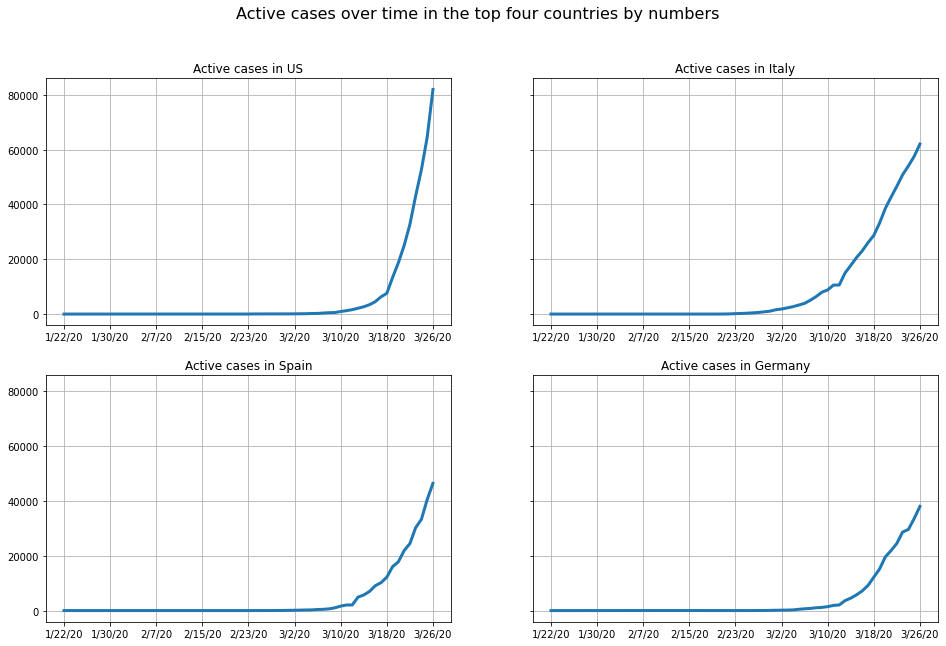

In [317]:
fig, ax = plt.subplots(2, 2, figsize=(16,10), sharey = True)

def plot_top4(da,num,xcol, ycol, title):
    ax[num].plot(da[xcol],da[ycol], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[num].grid(True)
    
plot_top4(top_four_all, (0,0), "Date", top_four[0] + ' active', 'Active cases in {}'.format(top_four[0]))
plot_top4(top_four_all, (0,1), "Date", top_four[1] + ' active', 'Active cases in {}'.format(top_four[1]))
plot_top4(top_four_all, (1,0), "Date", top_four[2] + ' active', 'Active cases in {}'.format(top_four[2]))
plot_top4(top_four_all, (1,1), "Date", top_four[3] + ' active', 'Active cases in {}'.format(top_four[3]))
fig.suptitle('Active cases over time in the top four countries by numbers', fontsize=16)

plt.show()

As of 27.03, US has surpassed Italy with the number of active cases and China in the number of total positives. 
<br>US curve of active cases has grown dramatically in the last two weeks. 
<br>Italy started a strong growth of cases around the carnival festivities in the third week of February whereas Germany's and Spain's curves of active cases started to go up at a fast pace around two weeks after.
<br>Question: Why the curve in US took momentum in such a short timeframe in comparison to Italy, Germany and Spain? Might it be related to number of tests done?

We compare the curves above with the one from China, the country with the most reported cases so far but with a declining number of new positive cases. 
<br> We added also the graph from South Korea where the active cases are starting to drop since mif March.
<br> In both countries the peak of active cases shows in the graphs around a month since the curve started to increase at a fast pace. 
<br>Both countries took strict measures to content the spread of the virus including lockdowns of hotspots, social distancing, self-isolation and closing of public places and schools.

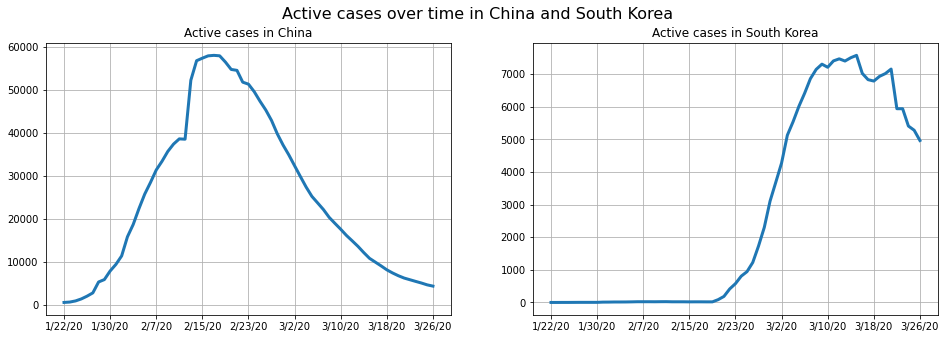

In [318]:
fig, ax = plt.subplots(1, 2, figsize = (16,5))
plot_top4(top_four_all, 0, "Date", 'China active', 'Active cases in China')
plot_top4(top_four_all, 1, "Date", 'South Korea active', 'Active cases in South Korea')
fig.suptitle('Active cases over time in China and South Korea', fontsize = 16)

plt.show()

# Country Analysis - Italy

Import the latest reports from the Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile. 
<br>There are four datasets:
1. da_national: National data (time series).
2. da_region: Regional data (time series).
3. da_daily_region: Latest daily data on regional level.
4. da_province: Province data.

<br>Date of the latest data to be gathered is yesterday to ensure the data is available as the files are updated daily at midnight. 
<br>We use the date variable "ieri" to build the urls dynamically. The date format used in the Italian repository differs from the one used by the CSSE at Johns Hopkins University, this is why we need to build it.

In [236]:
ieri = date.today() - timedelta(days=1)
ieri = ieri.strftime("%Y%m%d")

In [237]:
nat_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
reg_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
reg_daily_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-{}.csv".format(ieri)
prov_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv" 
da_national = get_raw_data(nat_url)
da_region = get_raw_data(reg_url)
da_daily_region = get_raw_data(reg_daily_url)
da_province = get_raw_data(prov_url)

We rename the columns to translate them to English.

In [238]:
da_national.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare',
       'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi', 'note_it',
       'note_en'],
      dtype='object')

In [239]:
da_national = da_national.rename(columns={'data':"timestamp", 'stato':"state", 
                            'ricoverati_con_sintomi':"hospitalized with symptoms", 
                            'terapia_intensiva':"intensive care",
                            'totale_ospedalizzati':"total hospitalized",
                            'isolamento_domiciliare':"self-isolation",
                            'totale_attualmente_positivi':"total currently positive", 
                            'nuovi_attualmente_positivi':"new positive",
                            'dimessi_guariti':"recovered", 
                            'deceduti':"fatalities", 
                            'totale_casi':"total positive", 
                            'tamponi':"total tested"})
da_national.head(2)

,timestamp,state,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623,NaN,NaN


In [235]:
da_region = da_region.rename(columns={'data':"date", 'stato':"state", 'codice_regione':"regional code", 
                          'denominazione_regione':"region", 'ricoverati_con_sintomi':"hospitalized with symptoms", 
                          'terapia_intensiva':"intensive care",'totale_ospedalizzati':"total hospitalized", 
                          'isolamento_domiciliare':"self-isolation", 
                          'totale_attualmente_positivi':"total currently positive", 
                          'nuovi_attualmente_positivi':"new positive",'dimessi_guariti':"recovered", 
                          'deceduti':"fatalities", 'totale_casi':"total positive", 'tamponi':"total tested"})
da_region.tail(2)

,date,state,regional code,region,lat,long,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested,note_it,note_en
670,2020-03-26T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,73,24,97,281,378,3,2,28,408,1203,NaN,NaN
671,2020-03-26T17:00:00,ITA,5,Veneto,45.434905,12.338452,1447,326,1773,4367,6140,395,508,287,6935,79759,NaN,NaN


In [202]:
da_daily_region = da_daily_region.rename(columns={'data':"date", 'stato':"state", 'codice_regione':"regional code", 
                          'denominazione_regione':"region", 'ricoverati_con_sintomi':"hospitalized with symptoms", 
                          'terapia_intensiva':"intensive care",'totale_ospedalizzati':"total hospitalized", 
                          'isolamento_domiciliare':"self-isolation", 
                          'totale_attualmente_positivi':"total currently positive", 
                          'nuovi_attualmente_positivi':"new positive",'dimessi_guariti':"recovered", 
                          'deceduti':"fatalities", 'totale_casi':"total positive", 'tamponi':"total tested"})
da_daily_region.head(2)

,date,state,regional code,region,lat,long,hospitalized with symptoms,intensive care,total hospitalized,self-isolation,total currently positive,new positive,recovered,fatalities,total positive,total tested,note_it,note_en
0,2020-03-26T17:00:00,ITA,13,Abruzzo,42.351222,13.398438,280,64,344,516,860,122,23,63,946,5488,NaN,NaN
1,2020-03-26T17:00:00,ITA,17,Basilicata,40.639471,15.805148,22,16,38,95,133,21,0,1,134,1046,NaN,NaN


## Time trends on national level 

<function matplotlib.pyplot.show(*args, **kw)>

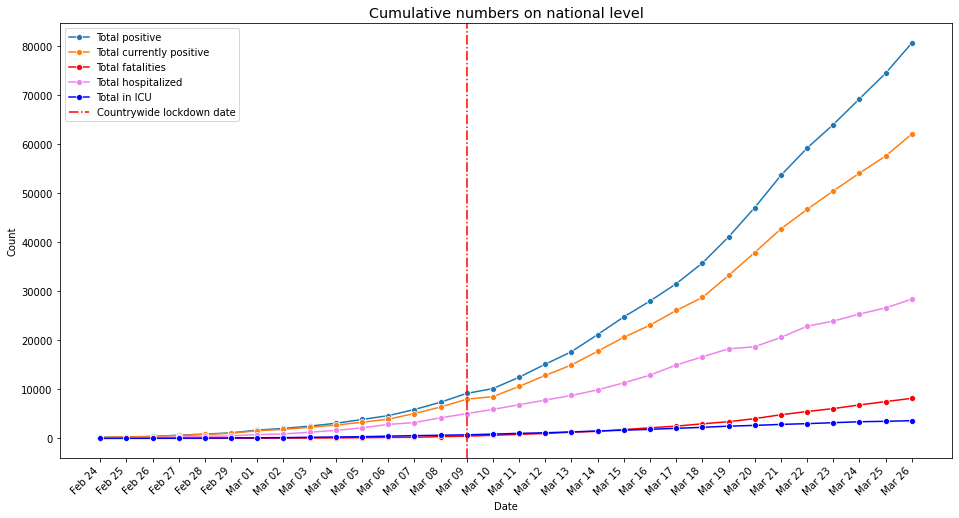

In [205]:
plt.figure(figsize=(16,8))
plt.title("Cumulative numbers on national level", size="x-large")
rng = da_national["timestamp"]
rng = [datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S').strftime("%b %d") for x in rng]
da_national["date"] = rng
sns.lineplot(x=da_national["date"], y=da_national["total positive"], 
             label = "Total positive", marker = "o")
sns.lineplot(x=da_national["date"], y=da_national["total currently positive"], 
             label = "Total currently positive", marker = "o")
sns.lineplot(x=da_national["date"], y=da_national["fatalities"], 
             label = "Total fatalities", marker = "o", color = "red")
sns.lineplot(x=da_national["date"], y=da_national["total hospitalized"], 
             label = "Total hospitalized", marker = "o", color="violet")
sns.lineplot(x=da_national["date"], y=da_national["intensive care"], 
             label = "Total in ICU", marker = "o", color="blue").set(xlabel = "Date", ylabel = "Count")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.axvline(x="Mar 09", ls="-.", c="red", label = "Countrywide lockdown date")
plt.legend(fontsize="medium")
plt.show

Active cases keep growing rapidly on national level. Following the trends from China and South Korea, we could infere that this behaviour is expected until at least one month since the countrywide lockdown.

## Country numbers in a nutshell

In [206]:
latest = da_national.loc[:,['total tested','total positive', 'total currently positive',
                            'recovered','self-isolation','total hospitalized',
                            'intensive care','fatalities']].tail(1)
latest["death rate [%]"] = 100*latest["fatalities"]/latest["total positive"]
latest.head()

,total tested,total positive,total currently positive,recovered,self-isolation,total hospitalized,intensive care,fatalities,death rate [%]
31,361060,80539,62013,10361,33648,28365,3612,8165,10.137946


In [207]:
ind = len(da_national) -1
perc = latest.drop(["total tested","death rate [%]"], axis=1)
perc = 100*perc/latest.loc[ind,"total tested"]

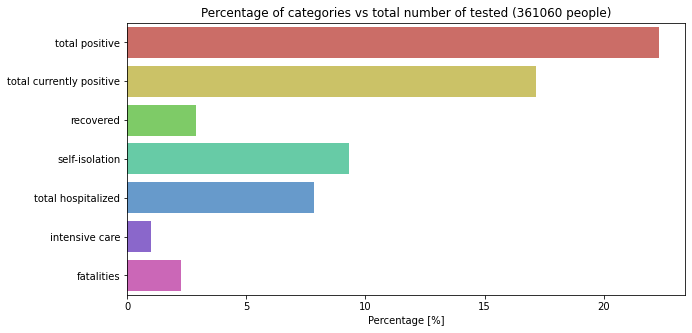

In [208]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Percentage of categories vs total number of tested ({} people)".format(latest.loc[ind,"total tested"]), 
          size="large")
ax = sns.barplot(data=perc, 
     orient="h",
     palette = 'hls').set(xlabel = "Percentage [%]")

*From all tested population we have the following figures in terms of percentage:* 

In [209]:
perc

,total positive,total currently positive,recovered,self-isolation,total hospitalized,intensive care,fatalities
31,22.306265,17.175262,2.869606,9.319227,7.856035,1.000388,2.261397


## Analysis on regional level

In [225]:
da_daily_region["percentage of active [%]"] = round(100*da_daily_region[
                                    "total currently positive"]/latest.loc[ind,"total currently positive"],2)
da_daily_region["percentage of total positive [%]"] = round(
                                    100*da_daily_region["total positive"]/latest.loc[ind,"total positive"],2)

In [226]:
summary_daily_region = da_daily_region[["region","total tested","total positive","total currently positive",
                 "percentage of active [%]",
                 "percentage of total positive [%]"]].sort_values(
                 by="total currently positive", ascending=False).head(4)

In [212]:
fig = px.treemap(da_daily_region,
                 path=['region'],
                 values= da_daily_region['total positive'],
                 title='Regions with Active Cases in Italy: status {}'.format(ieri),
                 hover_data=['total positive', 'total currently positive', 'recovered','fatalities'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Summary data per country is shown if you point on each country's block.

Lombardia is the region with the bigest share of cases of those currently active. 
<br>As the outbreak hit Lombardia first, the number of fatalities and recovered cases are higher, explaining the lower number of currently cases in comparison to the total of cases. 
<br>In the other regions, the outbreak started more recently, therefore the actual positive and total positive in those regions are very close to each other.

In [213]:
top_italy = da_daily_region.sort_values(by="total currently positive", ascending=False)["region"].head(4)

In [214]:
lomb_active_time = da_region[da_region["region"]=="Lombardia"][["date","total currently positive","fatalities","recovered"]]

<function matplotlib.pyplot.show(*args, **kw)>

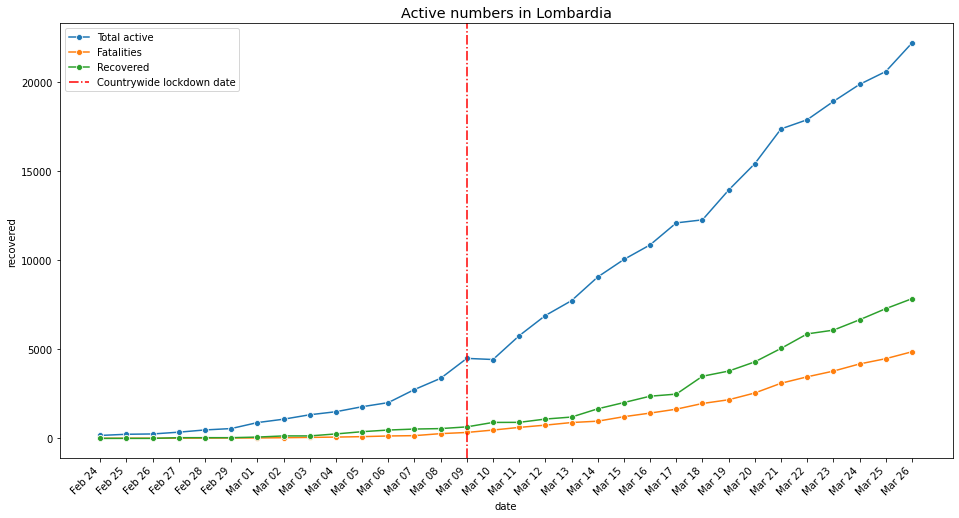

In [229]:
plt.figure(figsize=(16,8))
plt.title("Active numbers in Lombardia", size="x-large")
rng = lomb_active_time["date"]
rng = [datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S').strftime("%b %d") for x in rng]
lomb_active_time["date"] = rng
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["total currently positive"], 
             label = "Total active", marker = "o")
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["fatalities"], 
             label = "Fatalities", marker = "o")
sns.lineplot(x=lomb_active_time["date"], y=lomb_active_time["recovered"], 
             label = "Recovered", marker = "o")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.axvline(x="Mar 09", ls="-.", c="red", label = "Countrywide lockdown date")
plt.legend(fontsize="medium")
plt.show

### Top four regions with most active cases

In [233]:
summary_daily_region

,region,total tested,total positive,total currently positive,percentage of active [%],percentage of total positive [%]
9,Lombardia,87713,34889,22189,35.78,43.32
5,Emilia Romagna,42395,10816,8850,14.27,13.43
20,Veneto,79759,6935,6140,9.90,8.61
12,Piemonte,18054,6534,5950,9.59,8.11


In [259]:
top_four_italy = summary_daily_region["region"]

In [263]:
top_four_italy = top_four_italy.reset_index(drop=True)

In [277]:
top_four_italy[1]

'Emilia Romagna'

In [309]:
reg_1 = da_region[da_region["denominazione_regione"] == top_four_italy[0]]
reg_2 = da_region[da_region["denominazione_regione"] == top_four_italy[1]]
reg_3 = da_region[da_region["denominazione_regione"] == top_four_italy[2]]
reg_4 = da_region[da_region["denominazione_regione"] == top_four_italy[3]]

In [310]:
reg_4[["data","totale_attualmente_positivi"]].head()

,data,totale_attualmente_positivi
12,2020-02-24T18:00:00,3
33,2020-02-25T18:00:00,3
54,2020-02-26T18:00:00,3
75,2020-02-27T18:00:00,2
96,2020-02-28T18:00:00,11


In [311]:
def time_formatter(da):
    rng = da["data"]
    rng = [datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S').strftime("%b %d") for x in rng]
    da["data"] = rng
    return da

In [312]:
reg_1 = time_formatter(reg_1)
reg_2 = time_formatter(reg_2)
reg_3 = time_formatter(reg_3)
reg_4 = time_formatter(reg_4)

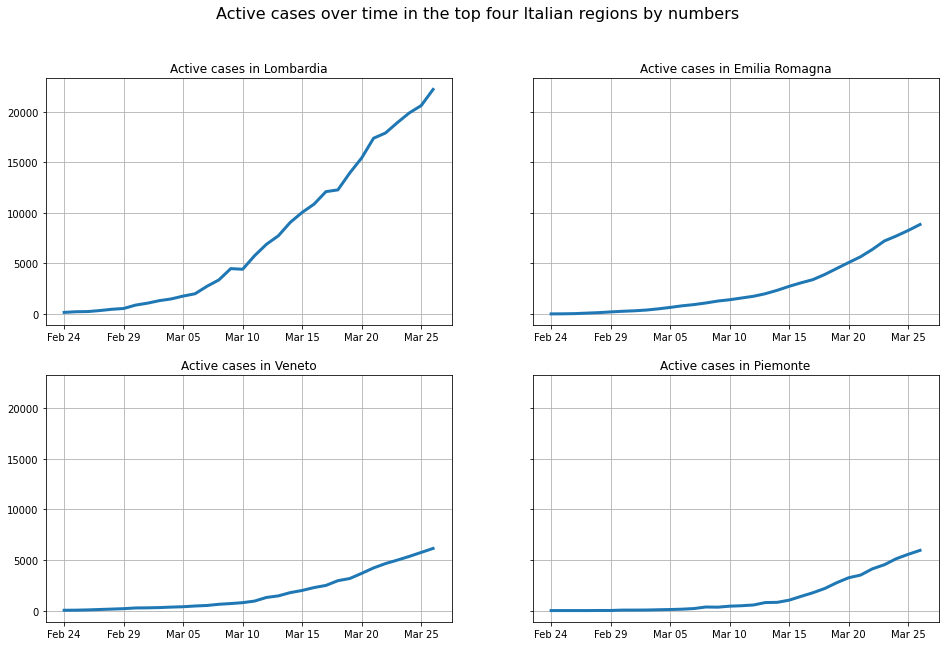

In [315]:
fig, ax = plt.subplots(2, 2, figsize=(16,10), sharey=True)


def plot_top4_it(da,num,xcol, ycol, title):
    ax[num].plot(da[xcol],da[ycol], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.AutoLocator())
    ax[num].grid(True)
    
plot_top4_it(reg_1, (0,0), "data", "totale_attualmente_positivi", 'Active cases in {}'.format(top_four_italy[0]))
plot_top4_it(reg_2, (0,1), "data", "totale_attualmente_positivi", 'Active cases in {}'.format(top_four_italy[1]))
plot_top4_it(reg_3, (1,0), "data", "totale_attualmente_positivi", 'Active cases in {}'.format(top_four_italy[2]))
plot_top4_it(reg_4, (1,1), "data", "totale_attualmente_positivi", 'Active cases in {}'.format(top_four_italy[3]))
fig.suptitle('Active cases over time in the top four Italian regions by numbers', fontsize=16)

plt.show()